<a href="https://colab.research.google.com/github/A01364577/Equipo_18_Navegacion_Autonoma/blob/main/deteccion_de_peatones_Keras_A01793062.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maestria en Inteligencia Artificial Aplicada
##Navegación Autónoma
###Actividad 4.1 - Ejercicio de clasificación con Keras
Equipo 18:

- Laura Irán González Ojeda - A01794099
- Emmanuel Francisco González Velázquez - A01364577
- Fabiola Sosa Hernández- A01240145
- Jorge Fernández Lara - A01793062
- Jonathan Puga Castellanos - A01795204

In [1]:
# Asegurarse de que se esté utilizando GPU
import tensorflow as tf
tf.test.gpu_device_name()

# Importación de Librerías
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from xml.etree import ElementTree
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
import numpy as np

In [2]:
# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
    # Obtener detalles de la GPU
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"Nombre de la GPU: {gpu.name}")
else:
    print("No hay GPU disponible.")

GPU está disponible.
Nombre de la GPU: /physical_device:GPU:0


In [3]:
# Cargar el archivo .json con el token de Kaggle y utilizar la API de Kaggle para descargar el archivo .zip del dataset
from google.colab import files
files.upload()

# Crear el directorio .kaggle y mover el archivo kaggle.json allí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la API de Kaggle
!pip install kaggle

# Descargar el archivo del conjunto de datos de Kaggle
!kaggle datasets download -d karthika95/pedestrian-detection --unzip -p /content/pedestrian_dataset

Saving pedestrian-detection-metadata (2).json to pedestrian-detection-metadata (2).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/karthika95/pedestrian-detection
License(s): unknown
100% 187M/187M [00:09<00:00, 24.0MB/s]
100% 187M/187M [00:09<00:00, 20.9MB/s]


In [4]:
# Se definen los nombres de las clases
class_names = ['person', 'person-like']
class_names_label = {name: i for i, name in enumerate(class_names)}

# Se definen los parámetros de la imagen
n_classes = 2
size = (200, 200)

In [5]:
def load_data():
    # Define los conjuntos de datos que se van a cargar: entrenamiento, prueba y validación.
    datasets = ['Train/Train', 'Test/Test', 'Val/Val']
    output = []  # Esta lista almacenará los datos cargados de cada conjunto.

    # Itera sobre cada conjunto de datos.
    for dataset in datasets:
        imags = []  # Lista para almacenar las imágenes cargadas.
        labels = []  # Lista para almacenar las etiquetas correspondientes.

        # Construye los caminos hacia los directorios de anotaciones y de imágenes.
        directoryA = "/content/pedestrian_dataset/" + dataset + "/Annotations"
        directoryIMG = "/content/pedestrian_dataset/" + dataset + "/JPEGImages/"

        # Lista y ordena los archivos en los directorios de anotaciones e imágenes.
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0  # Índice para iterar sobre las imágenes y los archivos xml de manera sincronizada.

        # Itera sobre cada archivo xml en el directorio de anotaciones.
        for xml in file:
            xmlf = os.path.join(directoryA, xml)  # Construye la ruta completa al archivo xml.
            dom = ElementTree.parse(xmlf)  # Analiza el archivo xml.
            vb = dom.findall('object')  # Encuentra todos los elementos 'object' en el archivo xml.
            label = vb[0].find('name').text  # Extrae el texto del primer 'name' encontrado en los elementos 'object'.
            labels.append(class_names_label[label])  # Convierte el nombre de la etiqueta a su correspondiente índice y lo añade a la lista de etiquetas.

            # Carga y procesa la imagen correspondiente.
            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)  # Lee la imagen desde el disco.
            curr_img = cv2.resize(curr_img, size)  # Redimensiona la imagen al tamaño deseado.
            imags.append(curr_img)  # Añade la imagen procesada a la lista de imágenes.
            i += 1  # Incrementa el índice para la próxima iteración.

        # Convierte las listas de imágenes y etiquetas a arrays de numpy y normaliza las imágenes.
        imags = np.array(imags, dtype='float32')
        imags = imags / 255  # Normaliza las imágenes para que los píxeles estén en el rango [0, 1].

        labels = np.array(labels, dtype='int32')

        # Añade los arrays de imágenes y etiquetas a la lista de salida.
        output.append((imags, labels))

    return output  # Devuelve la lista con los datos de todos los conjuntos.


In [6]:
# Cargar los datos utilizando la función load_data definida previamente.
# Esta función devuelve una lista de tuplas, donde cada tupla contiene dos arrays de numpy:
# uno para las imágenes y otro para las etiquetas correspondientes a cada conjunto de datos.
# La función devuelve los datos en el orden: entrenamiento, prueba y validación.
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()


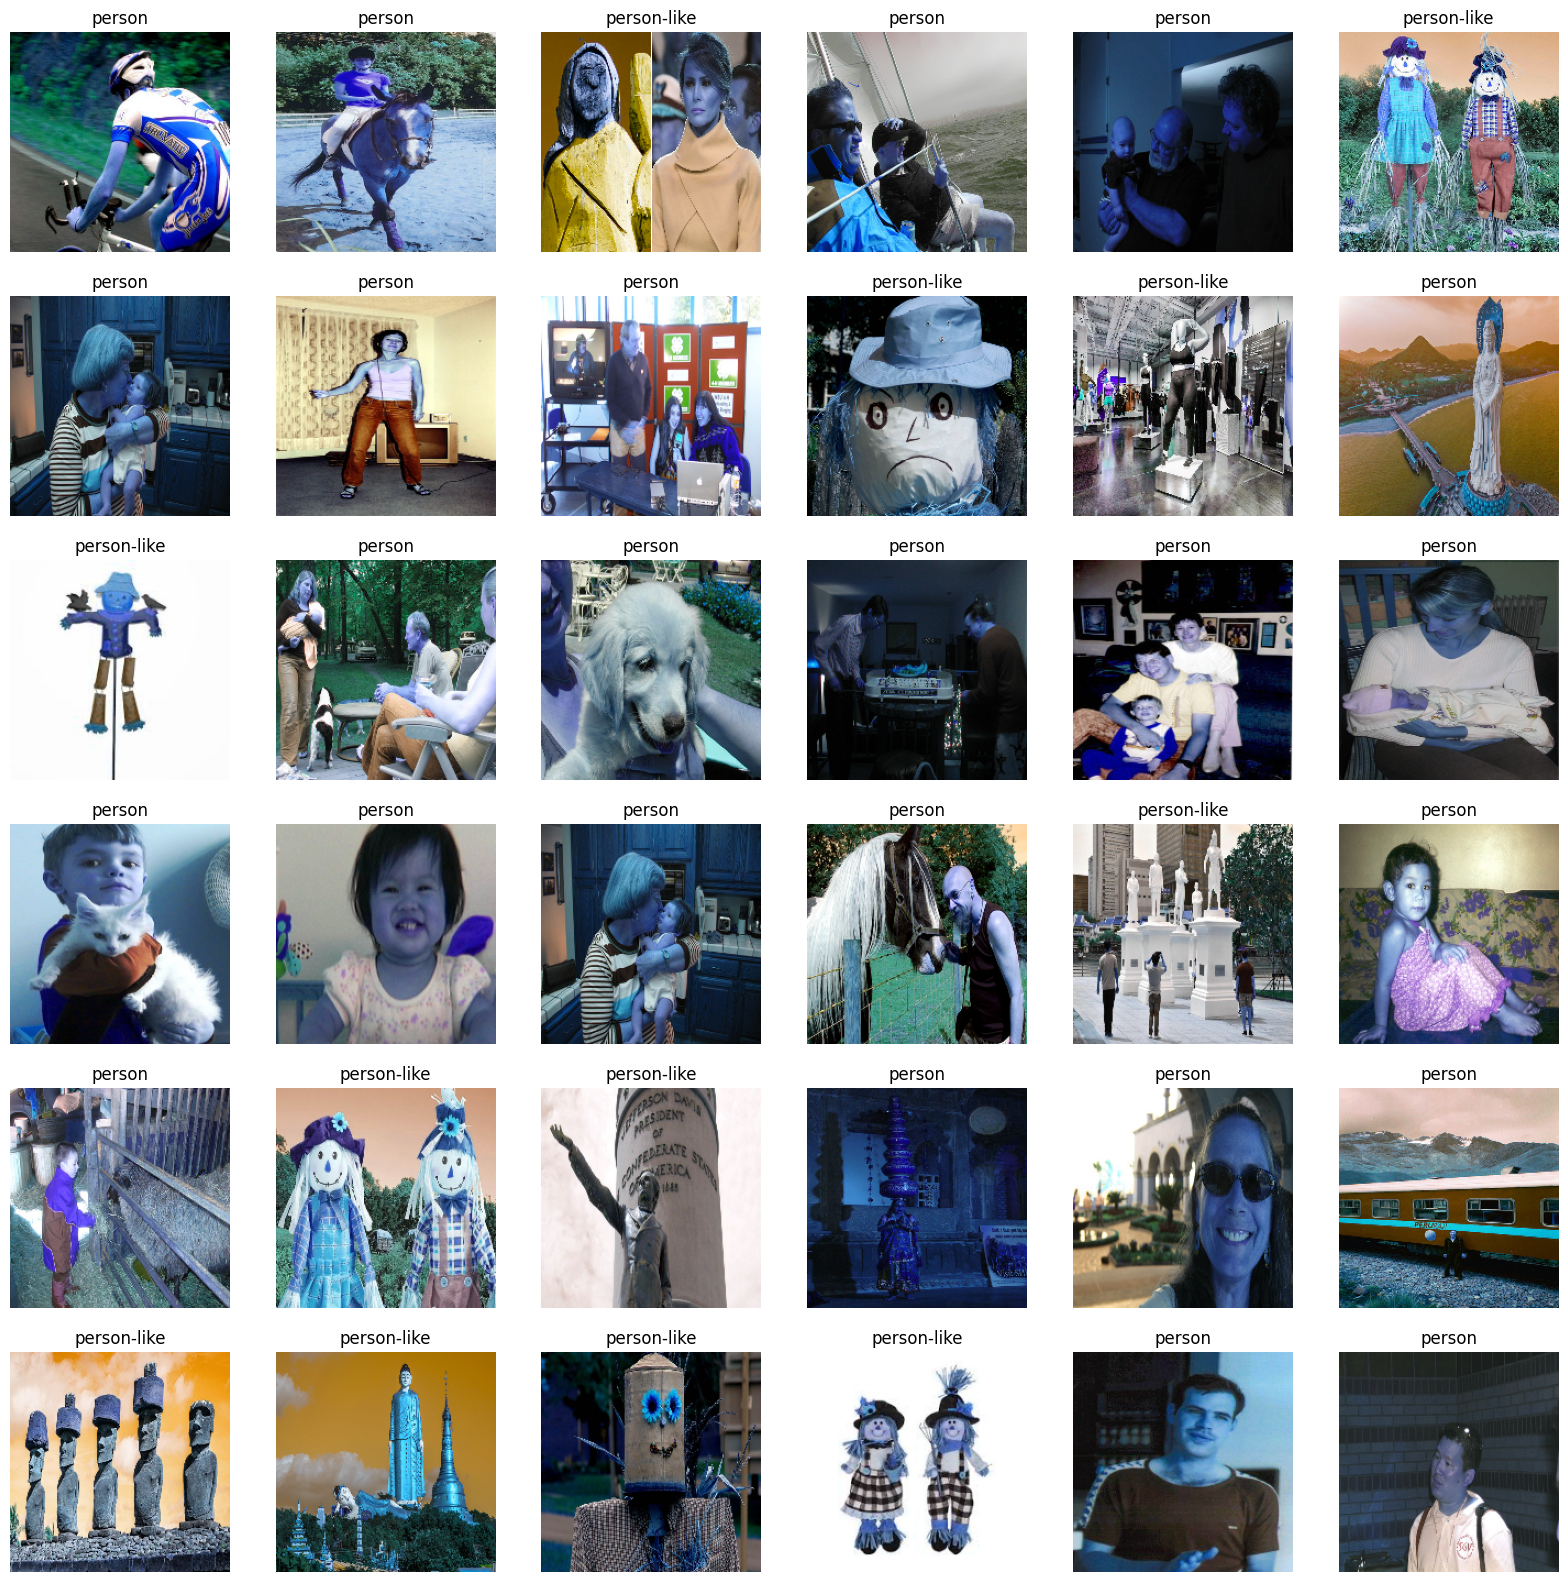

In [7]:
# Visualización de algunas imágenes
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.show()

In [8]:
# Define una función para extraer características HOG de un conjunto de imágenes.
def extract_hog_features(images):
    hog_features_accum = []  # Lista para acumular las características HOG de cada imagen.

    # Itera sobre cada imagen en el conjunto proporcionado.
    for img in images:
        # Convierte la imagen de color a escala de grises.
        # HOG se calcula generalmente sobre imágenes en escala de grises para reducir la complejidad computacional y mejorar la efectividad.
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calcula las características HOG de la imagen.
        # - orientations: Número de bins de orientación en el histograma de gradientes.
        # - pixels_per_cell: Tamaño de la celda (en píxeles) sobre la cual se normaliza el histograma.
        # - cells_per_block: Número de celdas por bloque. Normalización adicional sobre bloques para mejorar la robustez contra cambios de iluminación y sombras.
        # - transform_sqrt: Aplicación de la transformada de raíz cuadrada para normalización, que puede ayudar a reducir los efectos de las variaciones de iluminación.
        # - visualize: Si es True, la función también devuelve la imagen del HOG.
        # - feature_vector: Si es True, las características HOG se devuelven como un único vector por imagen (útil para entrenamiento de modelos).
        features, hog_img = hog(img_gray,
                                orientations=12,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(2, 2),
                                transform_sqrt=True,
                                visualize=True,
                                feature_vector=True)

        # Añade las características HOG de la imagen actual a la lista acumuladora.
        hog_features_accum.append(features)

    # Convierte la lista de características HOG acumuladas en un array de numpy y cambia el tipo a float64 para precisión.
    # np.vstack crea un array 2D donde cada fila es el vector de características de una imagen.
    return np.vstack(hog_features_accum).astype(np.float64)


In [9]:
# Extrae las características HOG del conjunto de imágenes de entrenamiento.
# 'train_images' contiene las imágenes del conjunto de entrenamiento sobre las cuales se calculan las características HOG.
# Las características HOG extraídas se almacenan en 'train_features'.
train_features = extract_hog_features(train_images)

# Extrae las características HOG del conjunto de imágenes de prueba.
# 'test_images' contiene las imágenes del conjunto de prueba. Las características HOG extraídas de estas imágenes
# se utilizan para evaluar la capacidad del modelo entrenado para generalizar a nuevos datos no vistos durante el entrenamiento.
test_features = extract_hog_features(test_images)

# Extrae las características HOG del conjunto de imágenes de validación.
# 'val_images' contiene las imágenes del conjunto de validación. Este conjunto puede ser usado para hacer ajustes
# en los parámetros del modelo durante el entrenamiento (por ejemplo, para evitar el sobreajuste).
val_features = extract_hog_features(val_images)


In [ ]:
print("Shape de train_features:", train_features.shape)
print("Shape de train_labels:", train_labels.shape)

Shape de train_features: (944, 5808)
Shape de train_labels: (944,)


In [10]:
# Importa MinMaxScaler de sklearn, una herramienta para escalar los datos a un rango específico, típicamente (0, 1).
from sklearn.preprocessing import MinMaxScaler

# Crea una instancia de MinMaxScaler. Este escalador ajusta los datos de tal manera que su distribución tendrá
# un valor mínimo de 0 y un valor máximo de 1.
scaler = MinMaxScaler()

# Escala las características de entrenamiento. 'fit_transform' primero ajusta el escalador a los datos de entrenamiento
# (calculando el máximo y mínimo), y luego transforma los datos de entrenamiento a su escala correspondiente.
train_features = scaler.fit_transform(train_features)

# Escala las características de prueba. 'transform' utiliza el mismo ajuste (mínimo y máximo) que se calculó
# con los datos de entrenamiento para transformar los datos de prueba. Esto asegura que ambos conjuntos de datos están
# en la misma escala y que no hay información del conjunto de prueba "filtrada" en el modelo durante el entrenamiento.
test_features = scaler.transform(test_features)

# Escala las características de validación de la misma manera que las características de prueba.
val_features = scaler.transform(val_features)


In [ ]:
from sklearn.utils import class_weight
# Balancear clases
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [11]:
# Importa la función 'class_weight' de scikit-learn para calcular pesos de clases
from sklearn.utils import class_weight

# Calcula los pesos de las clases para el conjunto de entrenamiento. Esto se hace para ayudar al modelo a equilibrar la importancia
# de cada clase durante el entrenamiento. Los pesos se calculan de tal manera que clases con menos muestras
# obtienen un mayor peso y viceversa. Esto ayuda a compensar el desequilibrio en la distribución de las clases.
# - 'class_weight='balanced'': Especifica que los pesos deben ser calculados de forma que se contrarreste el desequilibrio entre las clases.
# - 'classes=np.unique(train_labels)': Un array de todas las clases únicas en los datos de entrenamiento.
# - 'y=train_labels': El array de etiquetas de entrenamiento desde donde se extraen las clases para calcular los pesos.
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

# Convierte los pesos de clases calculados en un diccionario donde la clave es el índice de la clase
# y el valor es el peso correspondiente. Esto es útil para su uso directo en muchos modelos de aprendizaje
# automático de scikit-learn y Keras que aceptan pesos de clases en este formato.
class_weights_dict = dict(enumerate(class_weights))


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Inicializa un modelo secuencial. Un modelo secuencial en Keras es un contenedor lineal de capas.
model = Sequential()

# Añade una capa densa con 512 unidades/neuronas. 'activation='relu'' indica que la capa usará la función
# de activación ReLU para introducir no linealidades en el modelo. La primera capa densa también necesita
# saber cuál es la dimensión de entrada, que se especifica con 'input_dim'.
# 'kernel_regularizer=l2(0.01)' aplica una regularización L2 a los pesos de la capa, penalizando los pesos grandes
# para evitar el sobreajuste. La constante 0.01 es el factor de penalización.
model.add(Dense(units=512, activation='relu', input_dim=train_features.shape[1], kernel_regularizer=l2(0.01)))

# Añade una capa de Dropout que ayuda a prevenir el sobreajuste 'desactivando' aleatoriamente un porcentaje (50% aquí)
# de las conexiones neuronales durante el entrenamiento en cada paso de actualización de los datos de entrenamiento.
model.add(Dropout(0.5))

# Añade otra capa densa con 256 unidades/neuronas y regularización L2.
model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)))

# Añade otra capa de Dropout.
model.add(Dropout(0.5))

# Continúa añadiendo capas densas con regularización L2 y capas de Dropout.
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))

# Añade una capa densa final con una sola unidad y función de activación sigmoid.
# Esta capa es la capa de salida y se utiliza para la clasificación binaria.
model.add(Dense(units=1, activation='sigmoid'))


In [24]:
# Importa el optimizador Adam desde TensorFlow Keras.
from tensorflow.keras.optimizers import Adam

# Crea una instancia del optimizador Adam con una tasa de aprendizaje específica.
# La tasa de aprendizaje de 0.0001 es relativamente baja, lo que puede ayudar a asegurar una convergencia más suave y estable,
# pero podría hacer que el entrenamiento sea más lento.
optimizer = Adam(learning_rate=0.0001)

# Compila el modelo preparándolo para el entrenamiento. En este paso se configuran tres aspectos principales del modelo:
# 1. Optimizador: El método que se utilizará para actualizar los pesos de la red. Aquí se usa Adam, un optimizador
#    basado en el descenso de gradiente estocástico, conocido por ser eficaz en una amplia gama de problemas.
# 2. Función de pérdida: 'binary_crossentropy', adecuada para problemas de clasificación binaria. Esta función de pérdida
#    mide el "error" del modelo durante el entrenamiento, intentando minimizar la diferencia entre las predicciones y los
#    valores reales.
# 3. Métricas: Lista de métricas para ser evaluadas por el modelo durante el entrenamiento y la prueba. Aquí se usa 'accuracy',
#    que es una forma común de evaluar modelos de clasificación. Indica el porcentaje de etiquetas correctamente predichas.
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
# Importa las clases EarlyStopping y ReduceLROnPlateau desde TensorFlow Keras.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping: Este callback detiene el entrenamiento antes de que se completen todos los epochs si no hay mejora en
# la métrica que se está monitoreando, que en este caso es 'val_loss' (la pérdida en el conjunto de validación).
# - 'monitor='val_loss'': Esto especifica que el cambio que se debe monitorear para detener el entrenamiento es la pérdida de validación.
# - 'patience=10': El entrenamiento no se detendrá hasta que 'val_loss' no mejore en 10 epochs consecutivos.
# - 'restore_best_weights=True': Cuando se detiene el entrenamiento, los pesos del modelo se restauran a los valores correspondientes
#    al mejor epoch, basado en la menor pérdida de validación observada.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau: Este callback reduce la tasa de aprendizaje cuando una métrica deja de mejorar, lo que ayuda a hacer
# ajustes finos a los modelos cuando se acercan a un mínimo durante el entrenamiento.
# - 'monitor='val_loss'': La métrica a monitorear para reducir la tasa de aprendizaje es también la pérdida de validación.
# - 'factor=0.2': El factor por el que se multiplicará la tasa de aprendizaje cuando se active el callback. Una reducción
#    a 0.2 veces la tasa de aprendizaje actual.
# - 'patience=5': Si no hay mejora en la pérdida de validación durante 5 epochs consecutivos, la tasa de aprendizaje se reducirá.
# - 'min_lr=0.00001': Es el valor mínimo al que puede reducirse la tasa de aprendizaje.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [26]:
# Número de epochs: Define cuántas veces el algoritmo trabajará a través de todo el conjunto de datos de entrenamiento.
# Un 'epoch' representa una iteración completa sobre todos los datos de entrenamiento.
epochs=20

# Tamaño de batch: Número de muestras que se pasarán por la red antes de que se realice una actualización de los pesos
# mediante el descenso del gradiente. Un tamaño de batch de 64 es un valor común que equilibra la velocidad de entrenamiento y la memoria.
batch_size=64

# Entrenamiento del modelo utilizando el método 'fit'.
# - 'train_features': Características de entrenamiento (por ejemplo, características HOG de imágenes) utilizadas para entrenar el modelo.
# - 'train_labels': Etiquetas o respuestas correctas para el conjunto de entrenamiento.
# - 'validation_data': Tupla que contiene las características de validación y las etiquetas de validación.
#    Esto se utiliza para evaluar el modelo después de cada epoch, permitiendo monitorear el rendimiento del modelo en datos no vistos durante el entrenamiento.
# - 'epochs': Número total de epochs para entrenar el modelo, como se definió anteriormente.
# - 'batch_size': Tamaño del batch para el entrenamiento, como se definió anteriormente.
# - 'verbose=1': Configuración para que Keras muestre información detallada sobre el proceso de entrenamiento, incluyendo el progreso de cada epoch.
# - 'callbacks': Lista de callbacks para utilizar durante el entrenamiento. Aquí se incluyen 'early_stopping' y 'reduce_lr',
#    que ayudan a evitar el sobreajuste y ajustar la tasa de aprendizaje, respectivamente.
# - 'class_weight=class_weights_dict': Diccionario que proporciona pesos para las diferentes clases, compensando el desequilibrio en el conjunto de entrenamiento.
#    Esto asegura que clases menos representadas tengan una influencia proporcionalmente mayor durante el entrenamiento.
history = model.fit(train_features,
                    train_labels,
                    validation_data=(val_features, val_labels),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weights_dict)


Epoch 1/20
15/15 [==============================] - 2s 21ms/step - loss: 1.3163 - accuracy: 0.8835 - val_loss: 1.6527 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.2259 - accuracy: 0.9142 - val_loss: 1.6448 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1698 - accuracy: 0.9216 - val_loss: 1.6166 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1578 - accuracy: 0.9089 - val_loss: 1.5965 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0921 - accuracy: 0.9311 - val_loss: 1.5961 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0665 - accuracy: 0.9322 - val_loss: 1.6196 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 7/20
15/15 [==============================] - 0s 11

In [27]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=1)
print("Test Accuracy: ", test_acc)

4/4 [==============================] - 0s 6ms/step - loss: 1.6585 - accuracy: 0.7021
Test Accuracy:  0.7021276354789734


In [28]:
# Predicción de etiquetas del conjunto de datos de prueba
test_predictions = (model.predict(test_features) > 0.5).astype("int32")

8/8 [==============================] - 0s 8ms/step


In [29]:
# Cálculo de la matriz de confusión y clasificación
conf_matrix = confusion_matrix(test_labels, test_predictions)
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       136
           1       0.65      0.65      0.65        99

    accuracy                           0.70       235
   macro avg       0.69      0.69      0.69       235
weighted avg       0.70      0.70      0.70       235



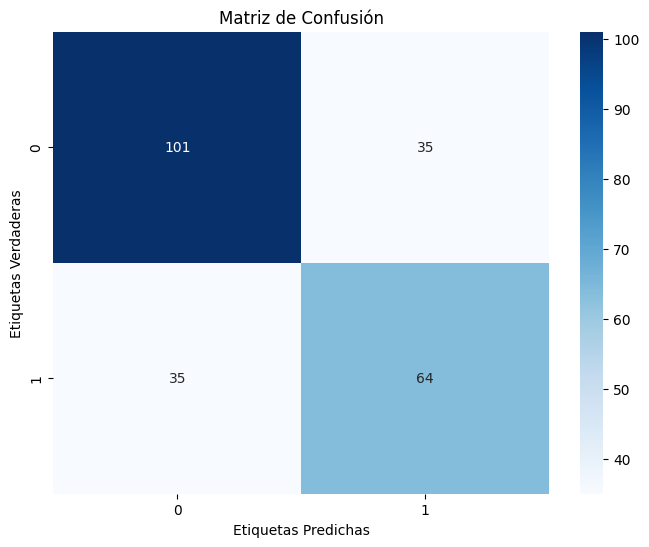

In [30]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.show()